In [14]:
# This is the same as the Dynamics_And_Measurement_PROTOTYPE but we batch process the files instead.

# This is the first file that should be run in the trajectory extraction workflow. It takes detection results from YOLOv8
# and perform tracking of vehicles until they exited the frame. 
# The result of this file is raw trajectories of vehicles. 


In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import cv2

In [3]:
x_collection = []
y_collection = []

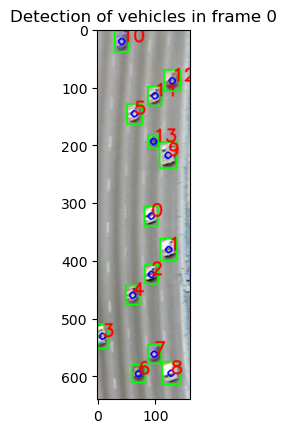

ids_to_track: [6 7 8]
Object 7 has left the frame at frame 58.
Object 8 has left the frame at frame 64.
Object 6 has left the frame at frame 66.
Done processing frame 0: completed at frame 74


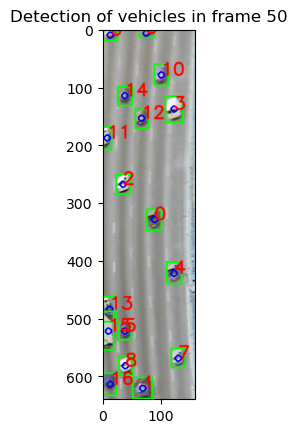

ids_to_track: [ 1  7  8 16]
Object 8 has left the frame at frame 105.
Object 7 has left the frame at frame 111.
Object 16 has left the frame at frame 116.
Object 1 has left the frame at frame 118.
Done processing frame 50: completed at frame 124


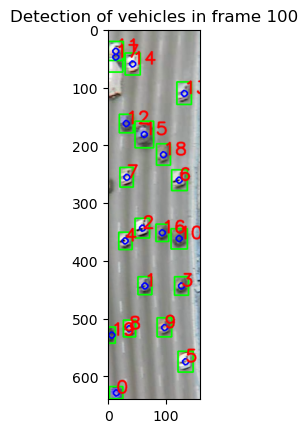

ids_to_track: [0 5]
Object 5 has left the frame at frame 160.
Object 0 has left the frame at frame 163.
Done processing frame 100: completed at frame 174


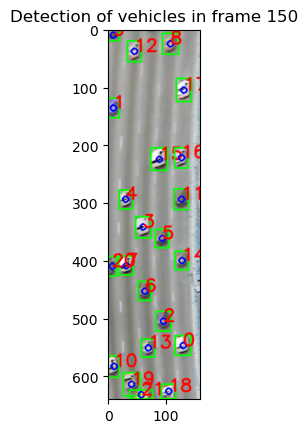

ids_to_track: [10 13 18 19 21]
Object 10 has left the frame at frame 212.
Object 13 has left the frame at frame 212.
Tracking failed for object 18 at frame 214.
Done processing frame 150: completed at frame 224


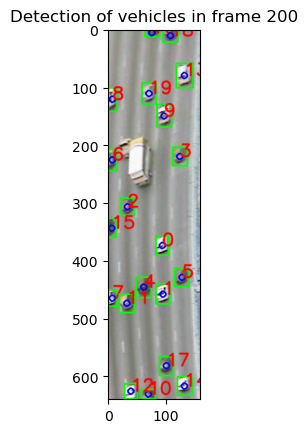

ids_to_track: [10 12 14 17]
Tracking failed for object 10 at frame 213.
Object 17 has left the frame at frame 261.
Object 12 has left the frame at frame 269.
Object 14 has left the frame at frame 273.
Done processing frame 200: completed at frame 274


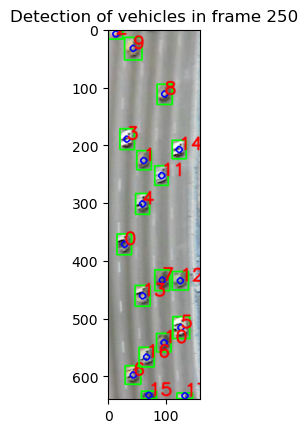

ids_to_track: [ 6 15 16 17]
Tracking failed for object 15 at frame 265.
Tracking failed for object 17 at frame 265.
Object 16 has left the frame at frame 312.
Object 6 has left the frame at frame 315.
Done processing frame 250: completed at frame 324


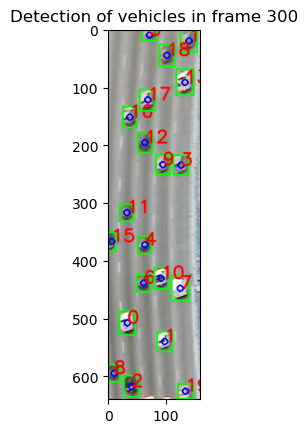

ids_to_track: [ 2  8 19]
Object 8 has left the frame at frame 355.
Object 2 has left the frame at frame 367.
Object 19 has left the frame at frame 370.
Done processing frame 300: completed at frame 374


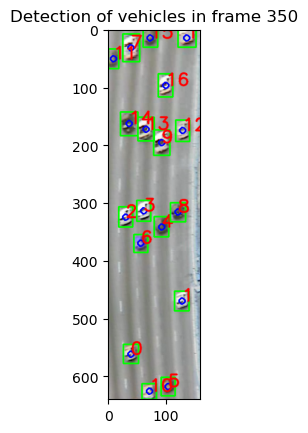

ids_to_track: [ 0  5 10]
Object 0 has left the frame at frame 410.
Object 10 has left the frame at frame 418.
Object 5 has left the frame at frame 420.
Done processing frame 350: completed at frame 424


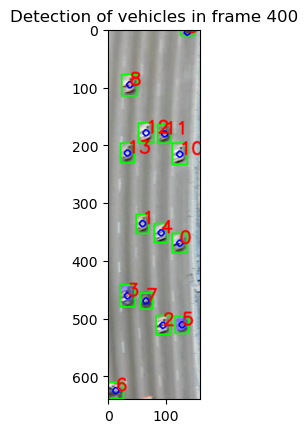

ids_to_track: [6]
Object 6 has left the frame at frame 471.
Done processing frame 400: completed at frame 474


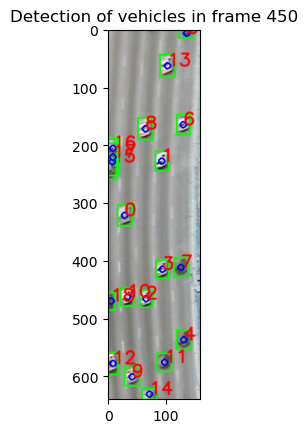

ids_to_track: [ 9 11 12 14]
Object 11 has left the frame at frame 506.
Object 9 has left the frame at frame 512.
Object 12 has left the frame at frame 518.
Tracking failed for object 14 at frame 518.
Done processing frame 450: completed at frame 524


In [4]:
init_frame_ids = range(0, 500, 50) # start, stop, step

for init_frame_id in init_frame_ids:
    # Load the corresponding data label
    detectionLabel = np.loadtxt('labels/frame{}.txt'.format(init_frame_id), delimiter=',') # x1, y1, x2, y2

    # Load the corresponding frame
    frame = cv2.imread('frames/frame{}.jpg'.format(init_frame_id))

    detections = []
    # Circle the detected objects
    for i in range(detectionLabel.shape[0]):
        cv2.rectangle(frame, (int(detectionLabel[i,0]), int(detectionLabel[i,1])), (int(detectionLabel[i,2]), int(detectionLabel[i,3])), (0, 255, 0), 2)
        center = (int((detectionLabel[i,0]+detectionLabel[i,2])/2), int((detectionLabel[i,1]+detectionLabel[i,3])/2))
        detections.append(center)
        cv2.circle(frame, center, 5, (0, 0, 255), 2)
        cv2.putText(frame, str(i), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Convert the detections to numpy array
    detections = np.array(detections)

    # Show the first frame with detected objects
    plt.imshow(frame)
    plt.title('Detection of vehicles in frame {}'.format(init_frame_id))
    plt.show()

    # ids_to_track are vehicles starting at the bottom of the image (y > 550)
    ids_to_track = np.where(detections[:,1] > 550)[0]
    print('ids_to_track: {}'.format(ids_to_track))

    # Ask the user to confirm the ids to track
    user_confirm_ids = input('Leave empty to confirm the algorithm\'s selection of tracking targets: ')
    if user_confirm_ids != '':
        ids_to_track = input('Please type the ids to track separated by comma: ')
        ids_to_track = [int(x) for x in ids_to_track.split(',')]
        print('Now tracking ids: {}'.format(ids_to_track))

    max_frames = 75

    x_vec = np.ones((len(ids_to_track), max_frames)) * (-1) # -1 means invalid
    y_vec = np.ones((len(ids_to_track), max_frames)) * (-1) # -1 means invalid

    # Initialize the tracker
    trackers = []
    failed_trackers = []

    for id in ids_to_track:
        tracker = cv2.TrackerCSRT_create()
        bbox = (detectionLabel[id,0], detectionLabel[id,1], detectionLabel[id,2]-detectionLabel[id,0], detectionLabel[id,3]-detectionLabel[id,1])
        # convert bbox to int
        bbox = [int(v) for v in bbox]
        tracker.init(frame, bbox)
        trackers.append(tracker)

    # Start tracking
    for frame_id in range(init_frame_id, init_frame_id + max_frames):
        frame = cv2.imread('frames/frame{}.jpg'.format(frame_id))
        for i, tracker in enumerate(trackers):
            success, box = tracker.update(frame)
            if success:
                (x, y, w, h) = [int(v) for v in box]
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
                center = (int(x+w/2), int(y+h/2))
                # Append the center to the trajectory
                if center[1] < 5:
                    # Object has left the frame
                    if i not in failed_trackers:
                        failed_trackers.append(i)
                        print('Object {} has left the frame at frame {}.'.format(ids_to_track[i], frame_id))
                if i not in failed_trackers:
                    # Only append if the tracker has not failed
                    x_vec[i, frame_id - init_frame_id] = center[0]
                    y_vec[i, frame_id - init_frame_id] = center[1]
                # Mark the center on the frame
                cv2.circle(frame, center, 5, (0, 0, 255), 2)
                cv2.putText(frame, str(ids_to_track[i]), center, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
            else:
                # print('Tracking failed for object {}'.format(ids_to_track[i]))
                if i not in failed_trackers:
                    failed_trackers.append(i)
                    print('Tracking failed for object {} at frame {}.'.format(ids_to_track[i], frame_id))
        # Remove the failed trackers
        # trackers = [tracker for i, tracker in enumerate(trackers) if i not in failed_trackers]
        # if frame_id % 20 == 0: # change to false 
        #     plt.imshow(frame)
        #     plt.title('Tracking of vehicles in frame {}'.format(frame_id))
        #     plt.show()

    for j in range(x_vec.shape[0]):
        x_collection.append(x_vec[j, :])
        y_collection.append(y_vec[j, :])
        
    print('Done processing frame {}: completed at frame {}'.format(init_frame_id, frame_id))


        


In [5]:
# Convert x_collection and y_collection to numpy array
x_collection = np.array(x_collection)
y_collection = np.array(y_collection)

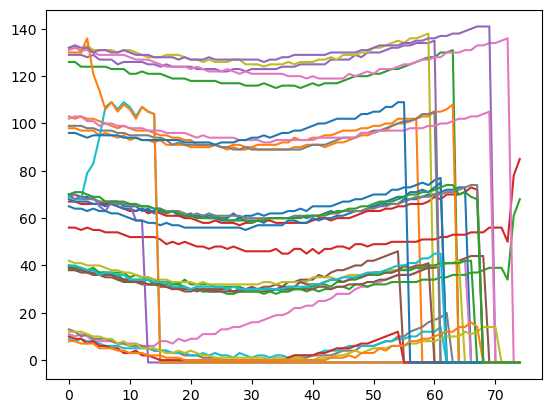

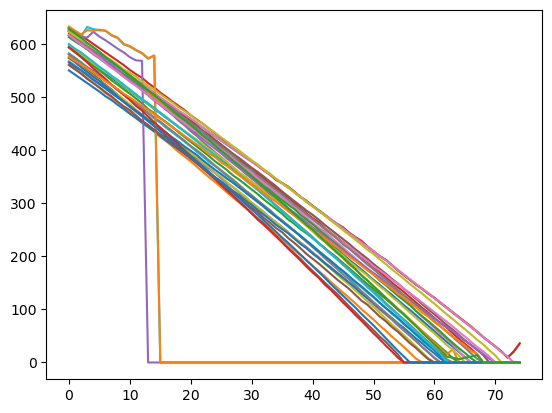

In [6]:
# Plot the trajectories
plt.figure()
for i in range(x_collection.shape[0]):
    plt.plot(x_collection[i,:]) # x

plt.figure()
for i in range(y_collection.shape[0]):
    plt.plot(y_collection[i,:]) # y

In [10]:
# Post-processing of trajectories

trajectory_length = 50

# Remove invalid trajectories
valid_x = []
valid_y = []

for i in range(x_collection.shape[0]):
    if y_collection[i, 20] < 0:
        # Invalid trajectory
        print('Invalid trajectory: {}'.format(i))
    else:
        valid_x.append(x_collection[i,:trajectory_length])
        valid_y.append(y_collection[i,:trajectory_length])

valid_x = np.array(valid_x)
valid_y = np.array(valid_y)


Invalid trajectory: 14
Invalid trajectory: 19
Invalid trajectory: 21


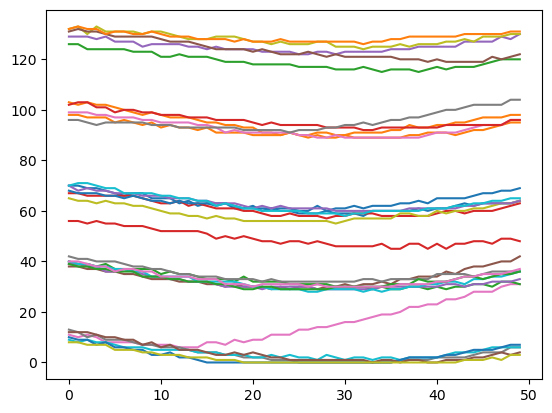

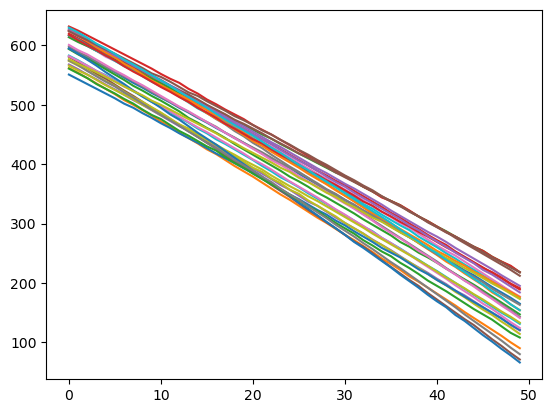

In [11]:
# Plot the trajectories
plt.figure()
for i in range(valid_x.shape[0]):
    plt.plot(valid_x[i,:]) # x

plt.figure()
for i in range(valid_y.shape[0]):
    plt.plot(valid_y[i,:]) # y

In [13]:
# Save the trajectories

np.save('x_sample_from_video.npy', valid_x)
np.save('y_sample_from_video.npy', valid_y)

In [15]:
# Now we are ready to move on to deriving the mean trajectory, the dynamics and measurement models.